# Spectral Clustering

Spectral clustering is an algorithm evolved from graph theory, and is widely used in clustering. Its main idea is to treat all data points as nodes that can be connected by edges with different weights. The edge weight is low between two nodes that are far away, and is high between two nodes that are close. Then, the purpose of clustering for the dataset of interest can be realized by graph-cut algorithms.

It performs a low-dimension embedding of the affinity matrix between samples, followed by k-means clustering of the components of the eigenvectors in the low-dimensional space.

Spectral clustering can help to indentify geometrically non-convex clusters that render traditional k-means algorithm inefficient. A possible drawback is that it is prone to outliers.

## Connect to HANA DB

In [27]:
from hana_ml import dataframe
from hana_ml.dataframe import ConnectionContext, create_dataframe_from_pandas
from data_load_utils import DataSets, Settings
url, port, user, pwd = Settings.load_config("../../config/e2edata.ini")
conn = dataframe.ConnectionContext(url, port, user, pwd)

## Test Cases

### Test on a Mocking Dataset

The first dataset of interest is a self-gererated mocking dataset, and is stored in the file *mocking_data_spc.csv*. We can load it into a *pandas.DataFrame* object using the *read_csv* function, and then convert it into a hana_ml.DataFrame using the *create_dataframe_from_pandas* function in hana_ml. The whole process is illustrated as follows:

In [28]:
import pandas as pd
mocking_data = pd.read_csv('../datasets/mocking_data_spc.csv')

In [29]:
from hana_ml.dataframe import create_dataframe_from_pandas
cluster_df = create_dataframe_from_pandas(conn, mocking_data, 'CLUSTERING_TEST_DATA_1', force=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


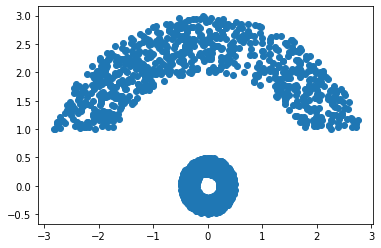

In [30]:
import matplotlib.pyplot as plt
plt.scatter(mocking_data['X'], mocking_data['Y'])
plt.show()

It is seen that the dataset contain two non-convex shaped clusters with different densities. We can test if they can be identified by spectral clustering.

In [31]:
from hana_ml.algorithms.pal.clustering import SpectralClustering

In [32]:
res = SpectralClustering(n_clusters=2, affinity='knn', n_neighbors=5).fit_predict(cluster_df, key='ID')

In [33]:
res.collect()

,ID,CLUSTER_ID
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
2115,2115,1
2116,2116,1
2117,2117,1
2118,2118,1


In [34]:
cluster0 = cluster_df.filter('ID IN (SELECT ID FROM ({}) WHERE CLUSTER_ID = 0)'.format(res.select_statement))

In [35]:
cluster0_data = cluster0.collect()

In [36]:
cluster1 = cluster_df.filter('ID IN (SELECT ID FROM ({}) WHERE CLUSTER_ID = 1)'.format(res.select_statement))

In [37]:
cluster1_data = cluster1.collect()

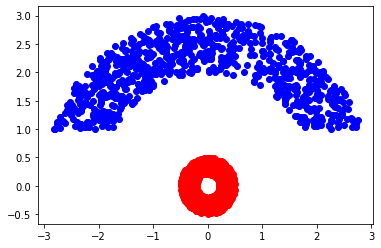

In [38]:
import matplotlib.pyplot as plt
plt.scatter(cluster0_data['X'], cluster0_data['Y'], color='blue')
plt.scatter(cluster1_data['X'], cluster1_data['Y'], color='red')
plt.show()

It is seen that the two clusters are successfully identified.

In contrast, the non-convexity of the two clusters make them difficult to be identified by KMeans, illustrated as follows:

In [39]:
from hana_ml.algorithms.pal.clustering import KMeans

In [40]:
kmres = KMeans(n_clusters=2).fit_predict(cluster_df, key='ID')

In [41]:
kmres.collect()

,ID,CLUSTER_ID,DISTANCE,SLIGHT_SILHOUETTE
0,0,1,0.902957,0.575963
1,1,0,1.929596,0.292843
2,2,1,1.156847,0.604091
3,3,0,1.953189,0.344330
4,4,0,2.497014,0.213777
...,...,...,...,...
2115,2115,0,0.381746,0.801737
2116,2116,0,0.494853,0.732461
2117,2117,0,0.342385,0.815704
2118,2118,0,0.559807,0.790662


In [42]:
kclust0 = cluster_df.filter('ID IN (SELECT ID FROM ({}) WHERE CLUSTER_ID = 0)'.format(kmres.select_statement))
kclust0_data = kclust0.collect()
kclust1 = cluster_df.filter('ID IN (SELECT ID FROM ({}) WHERE CLUSTER_ID = 1)'.format(kmres.select_statement))
kclust1_data = kclust1.collect()

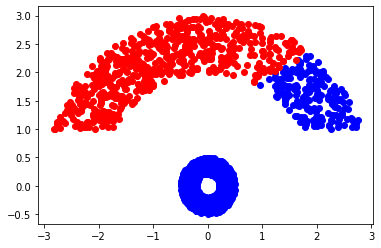

In [43]:
import matplotlib.pyplot as plt
plt.scatter(kclust0_data['X'], kclust0_data['Y'], color='blue')
plt.scatter(kclust1_data['X'], kclust1_data['Y'], color='red')
plt.show()

It is easy to see that the two obvious clusters fail to be identified by KMeans.

### Test on the Spiral Dataset

This dataset is taken from <a href='#spiral_source'>[1]</a> and can be downloaded <a href="http://cs.uef.fi/sipu/datasets/spiral.txt">here</a>. 

For convenience, we have downloaded the file, converted it to *csv* format, and stored it in local disk for reloading.

In [44]:
import pandas as pd
spiral_data = pd.read_csv('../datasets/spiral.csv')

The original dataset come with cluster labels, illustrated as follows:

In [45]:
spiral_data

,X,Y,CLUSTER
0,31.95,7.95,3
1,31.15,7.30,3
2,30.45,6.65,3
3,29.70,6.00,3
4,28.90,5.55,3
...,...,...,...
307,15.75,13.85,2
308,15.65,14.05,2
309,15.65,14.25,2
310,15.65,14.50,2


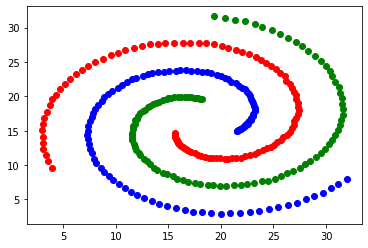

In [46]:
import matplotlib.pyplot as plt
plt.scatter(spiral_data['X'][spiral_data['CLUSTER']==1], spiral_data['Y'][spiral_data['CLUSTER']==1], color='green')
plt.scatter(spiral_data['X'][spiral_data['CLUSTER']==2], spiral_data['Y'][spiral_data['CLUSTER']==2], color='red')
plt.scatter(spiral_data['X'][spiral_data['CLUSTER']==3], spiral_data['Y'][spiral_data['CLUSTER']==3], color='blue')
plt.show()

Since the spectral clustering algorithm in hana_ml required an ID column, which is missing in the original dataset, we create one by row numbers.

In [47]:
spiral_wid = pd.DataFrame(dict(ID=range(spiral_data.shape[0]), X=spiral_data['X'], Y=spiral_data['Y']))#DataFrame with ID

Again, we transfer the above pandas.DataFrame object into HANA DB and generate a corresponding hana_ml.DataFrame object for it.

In [48]:
from hana_ml.dataframe import create_dataframe_from_pandas
spiral_df = create_dataframe_from_pandas(cc, spiral_wid, 'SPIRAL_DATA_TBL', force=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


Now we are ready to apply Spectral Clustering to the spiral dataset.

In [49]:
from hana_ml.algorithms.pal.clustering import SpectralClustering
res = SpectralClustering(n_clusters=3, affinity='knn', n_neighbors=5).fit_predict(spiral_df, key='ID')

In [50]:
scluster0 = spiral_df.filter('ID IN (SELECT ID FROM ({}) WHERE CLUSTER_ID = 0)'.format(res.select_statement))
scluster1 = spiral_df.filter('ID IN (SELECT ID FROM ({}) WHERE CLUSTER_ID = 1)'.format(res.select_statement))
scluster2 = spiral_df.filter('ID IN (SELECT ID FROM ({}) WHERE CLUSTER_ID = 2)'.format(res.select_statement))
sclust0_data = scluster0.collect()
sclust1_data = scluster1.collect()
sclust2_data = scluster2.collect()

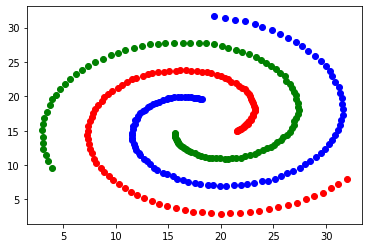

In [51]:
plt.scatter(sclust0_data['X'], sclust0_data['Y'], color='green')
plt.scatter(sclust1_data['X'], sclust1_data['Y'], color='red')
plt.scatter(sclust2_data['X'], sclust2_data['Y'], color='blue')
plt.show()

It is seen that the 3 spiral shaped clusters are successfully identified by spectral clustering.

### References

<a name='spiral_source'>[1]</a> P. Fränti and S. Sieranoja, **K-means properties on six clustering benchmark datasets**,
*Applied Intelligence*, 48 (12), 4743-4759, December 2018